In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip
from sklearn.metrics import f1_score
import numpy as np
from torchvision import transforms
import UNET
import UNET2
import dataloader
import matplotlib.pyplot as plt
#from tqdm import tqdm
import Predict
import tifffile
import skimage
import kornia
torch.manual_seed(17)
import random
import time
from patchify import patchify, unpatchify

In [2]:

train_section = [0.25,1]
test_section = [0,1]
# while choosing patch size need to consider the test volume size (depth) 
# in such way to include at least one patch 
patch_size = 32
batch_size = 1


In [3]:

# Set the paths to your data and target files

#data_path = 'data/Downsized_corespoinding_to_60micron_.tif'
#data_path = 'data/padded_noise_added_Downsized_corespoinding_to_60micron_.tif'
#data_path = 'data/padded_border_cropped_high_res_downsized.tif'
data_path ='data/registered/output/fixed_low_res.tif'
data = tifffile.imread(data_path)
print (data.shape)


#target_path = "data/padded_Downsized_to_60micron_56%.tif"
#target_path = "data/padded_binary.tif"
target_path = 'data/registered/output/registered_mask.tif'
target = tifffile.imread(target_path)
print (target.shape)


#test size is the same path but different part of the file will be selected

test_data_path = data_path
test_target_path= target_path


(123, 235, 165)
(123, 235, 165)


In [4]:
# Create instances of your training and test datasets and data loaders
train_dataset = dataloader.CustomDataset(data_path, target_path,
                                         section=train_section,
                                         patch_size=patch_size ,
                                         transform=1,
                                        step = 2)


test_dataset = dataloader.CustomDataset(test_data_path,
                                        test_target_path,
                                        section=test_section,
                                        patch_size=patch_size ,
                                        transform=None,
                                       step=patch_size)

train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

test_data_loader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=False)


data shape =  (128, 128, 128)
data max =  1.0
target shape =  (128, 128, 128)
target max =  1.0
data shape =  (128, 128, 128)
data max =  1.0
target shape =  (128, 128, 128)
target max =  1.0


In [5]:
def check_data_set_2 (dataset):
    fig, axs = plt.subplots(1, 3, figsize=(6, 6))

    for img, gt in dataset:
        print ('Shape of input data',img.shape)
        axs[0].imshow(img[0,0,0,:,:],'gray')
        axs[1].imshow(gt[0,0,0,:,:],'gray')
        color_image = img[0,0,0,:,:].numpy()
        color_image = color_image*255
        color_image = cv2.cvtColor(color_image.astype('uint8'), cv2.COLOR_GRAY2BGR)
        axs[2].imshow(skimage.segmentation.mark_boundaries(color_image,gt[0,0,0,:,:].numpy().astype('uint8')),'gray')
        
        #print ('img mean = ', img[0,0,0,:,:].mean())
        #print ('gt mean = ', gt[0,0,0,:,:].mean())
        break
    return img , gt

Shape of input data torch.Size([1, 1, 32, 32, 32])
Lnegth of traning data 79233


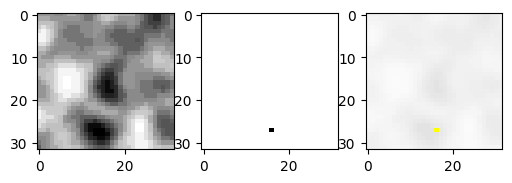

In [9]:
# run this cell multiple times and check the alignment of the input image and ground truth
img , gt = check_data_set_2(train_data_loader)
print ('Lnegth of traning data',len (train_data_loader))

In [9]:
# Training function
def train(model, train_data_loader, test_data_loader, num_epochs, learning_rate):
    #checking differetn criterions 
    #criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.L1Loss()
    #criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print (device)
    model.to(device)
    
    for epoch in range(num_epochs):
        t1 = time.time()
        model.train()
        train_loss = 0.0
        counter = 1
        for data, target in train_data_loader:
            print ('input shape {}'.format(data.shape),'Training progress for epoch {}'.format(epoch+1),
                   counter*100 //len(train_data_loader),'%', end = '\r')
            counter +=1

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            #If using a cirterion please uncomment this line and comment out the Kornia loss
            #loss = criterion(output, target)
            
            kwargs = {"alpha": 0.5, "gamma": 1.0, "reduction": 'mean'}
            loss = kornia.losses.binary_focal_loss_with_logits(output, target, **kwargs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        scheduler.step()
        t2 = time.time()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss / len(train_data_loader):.4f}, Time (min) = {round((t2-t1)/60)}")

        #Calculate F1-score on test set
        model.eval()
        with torch.no_grad():
            f1= []
            t_counter = 1
            for data, target in test_data_loader:
                if data.max()>1:
                    print ('Input data has issue !!!!')
                data, target = data.to(device), target.to(device)
                output = model(data)

                output = (output>0.6).float()
                output = output.cpu().numpy().flatten()
                target= target.cpu().numpy().flatten()
                f1.append(f1_score(target, output))
                t_counter +=1
                print ('testing progress for epoch {}%'.format(epoch+1),t_counter*100 //len(test_data_loader), end = '\r')
            print(f"F1-score: {np.array(f1).mean()}")

In [10]:
# Create an instance of the model
# two final models with different layers for different patch size were developed
model = UNET.UNet(in_channels=1, out_channels=1)
#model = UNET2.UNet(in_channels=1, out_channels=1)

# Set the hyperparameters
num_epochs = 60
learning_rate = 0.00001
import warnings
warnings.filterwarnings("ignore")
# Train the model
train(model, train_data_loader, test_data_loader, num_epochs, learning_rate)

cuda
Epoch [1/60], Training Loss: 0.0228, Time (min) = 49progress for epoch 1 100 %
F1-score: 0.9900656414387077% 101
Epoch [2/60], Training Loss: 0.0053, Time (min) = 49progress for epoch 2 100 %
F1-score: 0.9908736268733078% 101
Epoch [3/60], Training Loss: 0.0039, Time (min) = 49progress for epoch 3 100 %
F1-score: 0.9911897793009901% 101
Epoch [4/60], Training Loss: 0.0032, Time (min) = 49progress for epoch 4 100 %
F1-score: 0.9907759675726309% 101
Epoch [5/60], Training Loss: 0.0027, Time (min) = 49progress for epoch 5 100 %
F1-score: 0.9939018508298336% 101
Epoch [6/60], Training Loss: 0.0023, Time (min) = 49progress for epoch 6 100 %
F1-score: 0.9937438459768948% 101
Epoch [7/60], Training Loss: 0.0021, Time (min) = 49progress for epoch 7 100 %
F1-score: 0.9926453801237121% 101
Epoch [8/60], Training Loss: 0.0019, Time (min) = 49progress for epoch 8 100 %
F1-score: 0.9928396873800328% 101
Epoch [9/60], Training Loss: 0.0017, Time (min) = 49progress for epoch 9 100 %
F1-score: 0.

torch.Size([1, 1, 32, 32, 32])


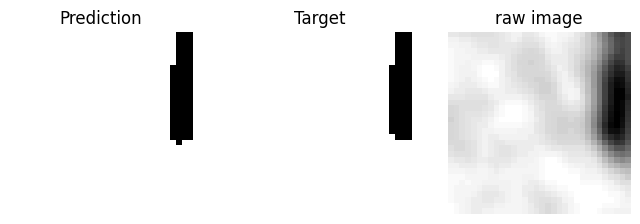

In [16]:
for data, target in train_data_loader:
    print (data.shape)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data = data.to(device)
    prediction = model(data)
    data = data.cpu()
    prediction = prediction.cpu()
                #predicted = output.argmax(dim=1)

    prediction = (prediction>0.5).float()
    fig, axes = plt.subplots(1, 3, figsize=(8, 6))
    axes[0].imshow(prediction[0,0,7,:,:], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Prediction')
    
    axes[1].imshow(target[0,0,7,:,:], cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Target')
    
    axes[2].imshow(data[0,0,7,:,:], cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('raw image')

    break



In [17]:
image = tifffile.imread(data_path)
target = tifffile.imread(target_path)
print ('image shape = ',image.shape)

image shape =  (123, 235, 165)


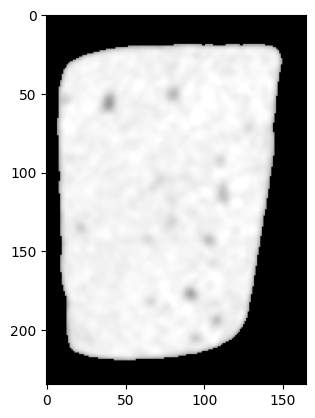

In [18]:
plt.imshow(image[10],'gray')

In [19]:
all_patches = np.zeros((1, patch_size, patch_size, patch_size))
target_patches = np.zeros((1, patch_size, patch_size, patch_size))
model.eval()
with torch.no_grad():
    for data, target in test_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        output = (output>0.5).float()
        output = output.cpu().numpy()[0]
        target = target.cpu().numpy()[0]
        all_patches = np.concatenate((all_patches,output), axis=0)
        target_patches = np.concatenate((target_patches,target), axis=0)
    all_patches = all_patches[1:,:,:,:]
    target_patches = target_patches[1:,:,:,:]
    print ('before reshape',all_patches.shape)
    #print (test_dataset.patchy_shape)
    all_patches=all_patches.reshape(test_dataset.patchy_shape)
    target_patches = target_patches.reshape(test_dataset.patchy_shape)
    output = unpatchify(all_patches, test_dataset.original_shape)
    target = unpatchify(target_patches, test_dataset.original_shape)
    print ('final output shape',output.shape)
    print ('final target shape',target.shape)

before reshape (64, 32, 32, 32)
final output shape (128, 128, 128)
final target shape (128, 128, 128)


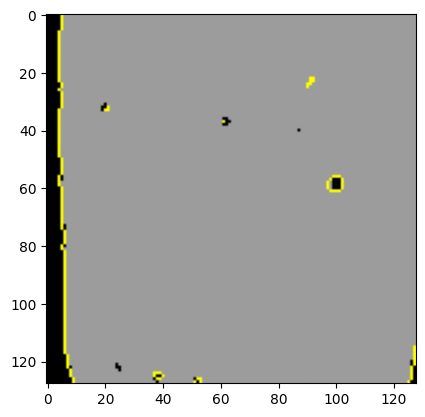

In [38]:
#visual check
n=100
color_image = cv2.cvtColor((target[n]*255).astype('uint8'), cv2.COLOR_GRAY2BGR)
plt.imshow(skimage.segmentation.mark_boundaries(color_image*100,output[n].astype('uint8')),'gray')

In [43]:
tifffile.imwrite('3D_Unet_32_32_32.tif',output)

In [40]:
#save model
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

checkpoint = {"state_dict": model.state_dict()}
save_checkpoint(checkpoint)

=> Saving checkpoint


In [ ]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

In [ ]:
def padd_to_proper(data):
    padded_image = np.pad(data[:,:,16:], ((0, 128-123), (11,10), (0, 0)), mode='constant') 
    return padded_image[:,:,:-21]

In [ ]:
def padd_to_proper_2(data):
    padded_image = np.pad(data[:,53:-54,16:], ((0, 128-123), (0,0), (0, 0)), mode='constant') 
    return padded_image[:,:,:-21]

In [ ]:
def contrast_stretching(input_image):
    # Contrast stretching + Normalizing 0-255
    p2, p98 = np.percentile(input_image, (2, 98))
    stretched_image = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))

    
    return stretched_image

def padd_to_proper(data):
    padded_image = np.pad(data[:,:,16:], ((0, 128-123), (11,10), (0, 0)), mode='constant') 
    return padded_image[:,:,:-21]
    

def predict_for_one_patch(img, model):
    
    img = contrast_stretching(img)
    img = torch.from_numpy(img).float()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)
    #print ('img max before going to model',img.max())
    output = model(img)
    output = output.cpu()
    output = output.detach().numpy()
    output [output >= 0.5] = 1
    output [output < 0.5] = 0
    #output = output[:,0,:,:,:]
    return output

def prediction (img, patch_size_, model):
    
    reshaped_img = padd_to_proper(img)
    img = reshaped_img
    
    original_img_shape = img.shape
    
    #image into patches
    img = patchify(img,(patch_size_, patch_size_, patch_size_) ,  step=patch_size_ )
    
    # image shape after patching
    original_patches_shape = img.shape
    
    
    img = img.reshape(img.shape[0]*img.shape[1]*img.shape[2],1,
                         patch_size_,patch_size_,patch_size_ )
    
    output = np.zeros_like(img)
    for i in range (img.shape[0]):
        output[i]= predict_for_one_patch(img[i:i+1], model)


    
    output = output[:,0,:,:,:]
    output= output.reshape(original_patches_shape)
    
    output = unpatchify(output, original_img_shape)
    
    return reshaped_img, output


In [ ]:
input_data = tifffile.imread(data_path)
#input_data , output = prediction(input_data,patch_size,model=model)
gt = padd_to_proper(tifffile.imread(target_path))

In [ ]:
plt.imshow(output[20],'gray')
print ('test section is layers ', input_data.shape[0]*np.array(test_section))

In [ ]:
#visual check
n=10
color_image = cv2.cvtColor(gt[n].astype('uint8'), cv2.COLOR_GRAY2BGR)
plt.imshow(skimage.segmentation.mark_boundaries(color_image*100,output[n].astype('uint8')),'gray')

In [ ]:
#visual check
color_image = cv2.cvtColor((input_data[:20][n]*255).astype('uint8'), cv2.COLOR_GRAY2BGR)
plt.imshow(skimage.segmentation.mark_boundaries(color_image,output[n].astype('uint8')),'gray')

In [ ]:
color_image = cv2.cvtColor(input_data[n].astype('uint8'), cv2.COLOR_GRAY2BGR)
plt.imshow(skimage.segmentation.mark_boundaries(color_image,(gt[n]).astype('uint8')),'gray')
n=0